In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import pandas as pd
from os.path import abspath

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv(abspath('../../../data/MSFT/MSFT.csv'), index_col=0, parse_dates=['Date'])

df.columns.name = df.index.name
df.index.name = None

df = df.filter(['Date', 'Open'])
print(df.shape)
df.head()

(9064, 1)


Date,Open
1986-03-13,0.088542
1986-03-14,0.097222
1986-03-17,0.100694
1986-03-18,0.102431
1986-03-19,0.099826


In [4]:
# Split the df into a training set and a test set
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_set, test_set = train_test_split(df, test_size=0.05, shuffle=False)

n_features = 1

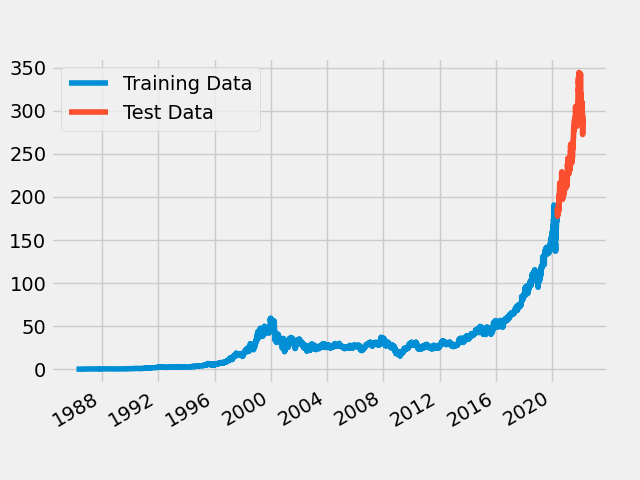

In [5]:
# Plot the training and testing data
train_set.Open.plot(label='Training Data')
test_set.Open.plot(label='Test Data')
plt.legend()

In [6]:
from sklearn.preprocessing import MinMaxScaler

transformer = MinMaxScaler()
train_scaled = transformer.fit_transform(train_set)
test_scaled = transformer.fit_transform(test_set)

In [7]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # type: ignore

n_input = 60

train_generator=TimeseriesGenerator(train_scaled,
                                     train_scaled,
                                      length=n_input,
                                      batch_size=32)

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

LSTM_UNITS = 20

model = Sequential()
model.add(LSTM(units=LSTM_UNITS, input_shape=(n_input, n_features)))
model.add(Dense(units=1))
model.summary()

Metal device set to: AMD Radeon Pro 560

systemMemory: 16.00 GB
maxCacheSize: 2.00 GB



2022-02-27 18:46:08.736484: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-27 18:46:08.737180: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-27 18:46:08.737397: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20)                1760      
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Create an EarlyStopping callback
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=5)

In [10]:
from tensorflow.keras.metrics import RootMeanSquaredError
from stock_market_predictions.forecasting.adam import Adam

model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=[RootMeanSquaredError()])
model.fit(train_generator, epochs=100, callbacks=[early_stopping])

Epoch 1/100
268/268 [==============================] - 64s 233ms/step - loss: 0.0182 - root_mean_squared_error: 0.1348
Epoch 2/100
268/268 [==============================] - 58s 216ms/step - loss: 5.6336e-04 - root_mean_squared_error: 0.0237
Epoch 3/100
268/268 [==============================] - 60s 224ms/step - loss: 1.8237e-04 - root_mean_squared_error: 0.0135
Epoch 4/100
268/268 [==============================] - 57s 212ms/step - loss: 1.7783e-04 - root_mean_squared_error: 0.0133
Epoch 5/100
268/268 [==============================] - 56s 211ms/step - loss: 2.1818e-04 - root_mean_squared_error: 0.0148
Epoch 6/100
268/268 [==============================] - 60s 222ms/step - loss: 1.6139e-04 - root_mean_squared_error: 0.0127
Epoch 7/100
268/268 [==============================] - 56s 210ms/step - loss: 2.2082e-04 - root_mean_squared_error: 0.0149
Epoch 8/100
268/268 [==============================] - 53s 199ms/step - loss: 1.0700e-04 - root_mean_squared_error: 0.0103
Epoch 9/100
268/268 

In [11]:
model.save(abspath('../../../logs/MSFT/'))

2022-02-27 19:13:27.149118: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /Users/aditya/Programming/stock-market-predictions/logs/MSFT/assets


INFO:tensorflow:Assets written to: /Users/aditya/Programming/stock-market-predictions/logs/MSFT/assets


In [12]:
inputs = df[len(df)-len(test_set)-60 : ].values
inputs = inputs.reshape(-1,1)
inputs = transformer.transform(inputs)

In [13]:
import numpy as np

x_test = []
for i in range(60,len(inputs)):
    x_test.append(inputs[i-60:i, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print(x_test.shape)

(454, 60, 1)


In [14]:
predicted = model.predict(x_test)
predicted = transformer.inverse_transform(predicted)

In [15]:
print(predicted.shape)

# Convert the predicted values to a dataframe
predicted_df = pd.DataFrame(predicted)

# Rename the column to "Open"
predicted_df.columns = ['Open']

# Add a new column called "Date" that has the same index as the other dataframe
predicted_df['Date'] = df[len(df)-len(test_set)-0 : ].index

# Set the 'Date' column as the index
predicted_df = predicted_df.set_index('Date')

predicted_df.head()

(454, 1)


,Open
Date,
2020-05-11,183.652374
2020-05-12,184.925873
2020-05-13,186.118988
2020-05-14,186.344498
2020-05-15,184.945633


<AxesSubplot:xlabel='Date'>

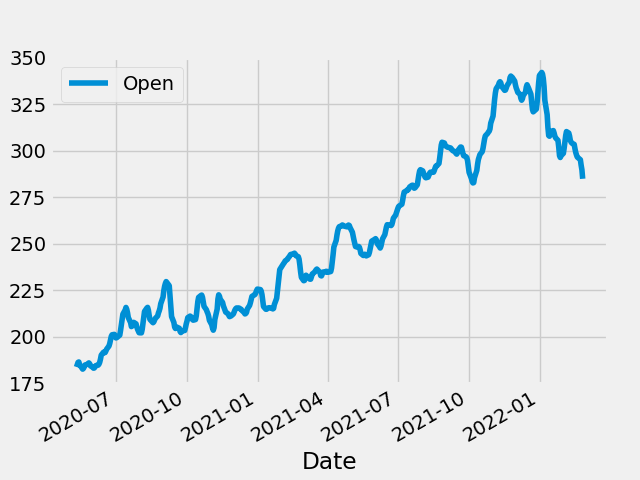

In [16]:
# Plot the predicted values
predicted_df.plot(label='Predicted')

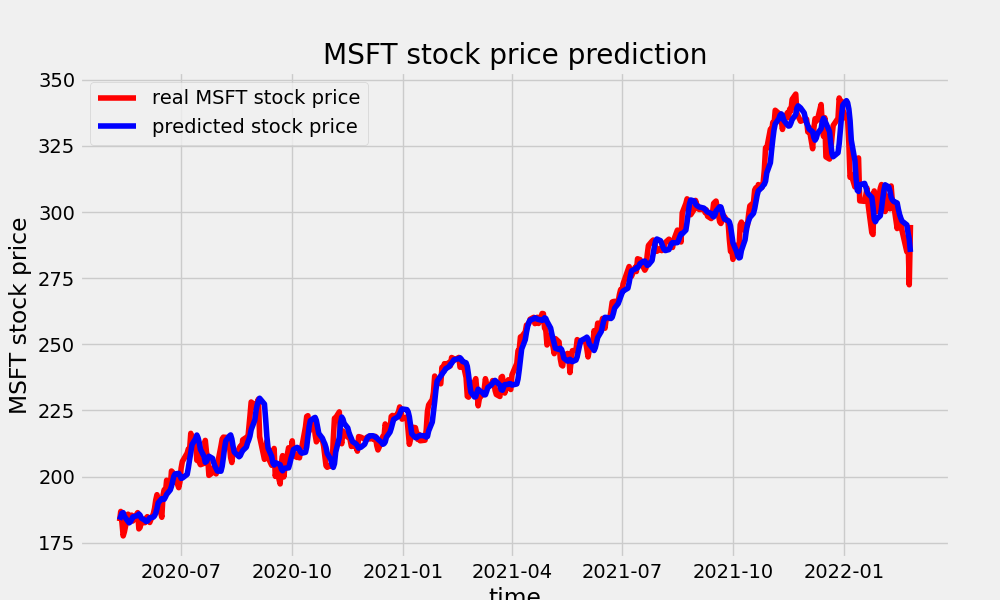

In [17]:
def plot_predictions(test, predicted):
    plt.figure(4, figsize=(10,6))
    plt.plot(test, color="red", label="real MSFT stock price")
    plt.plot(predicted, color="blue", label="predicted stock price")
    plt.title("MSFT stock price prediction")
    plt.xlabel("time")
    plt.ylabel("MSFT stock price")
    plt.legend()
    plt.show()

plot_predictions(test_set, predicted_df)

In [18]:
import math
from sklearn.metrics import mean_squared_error

def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("the root mean squared error is: {}".format(rmse))
    return rmse

RMSE = return_rmse(test_set, predicted)

the root mean squared error is: 5.464262537420904
